In [1]:
import urllib.request
import os
import zipfile
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile

In [2]:
data_url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip"
data_file_name = "catsdogs.zip"
download_dir = '/tmp/'
urllib.request.urlretrieve(data_url, data_file_name)
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()

In [3]:
print("Number of cat images:", len(os.listdir('/tmp/PetImages/Cat/')))
print("Number of dog images:", len(os.listdir('/tmp/PetImages/Dog/')))

Number of cat images: 12501
Number of dog images: 12501


In [4]:
os.mkdir('/tmp/cats-v-dogs')
os.mkdir('/tmp/cats-v-dogs/training')
os.mkdir('/tmp/cats-v-dogs/testing')
os.mkdir('/tmp/cats-v-dogs/training/cats')
os.mkdir('/tmp/cats-v-dogs/training/dogs')
os.mkdir('/tmp/cats-v-dogs/testing/cats')
os.mkdir('/tmp/cats-v-dogs/testing/dogs')

In [5]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [6]:
print("Number of training cat images", len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print("Number of training dog images", len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print("Number of testing cat images", len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print("Number of testing dog images", len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

Number of training cat images 11250
Number of training dog images 11250
Number of testing cat images 1250
Number of testing dog images 1250


In [7]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [8]:
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
urllib.request.urlretrieve(weights_url, weights_file)

pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top=False,
                                weights=None)

pre_trained_model.load_weights(weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [9]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

In [10]:
model.compile(optimizer=RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=10,
            verbose=1)

Epoch 1/10
200/225 [=========================>....] - ETA: 17s - loss: 0.3778 - acc: 0.8658

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

225/225 [==============================] - 172s 726ms/step - loss: 0.3606 - acc: 0.8706 - val_loss: 0.1054 - val_acc: 0.9552
Epoch 2/10
225/225 [==============================] - 161s 718ms/step - loss: 0.1551 - acc: 0.9349 - val_loss: 0.0869 - val_acc: 0.9704
Epoch 3/10
225/225 [==============================] - 161s 716ms/step - loss: 0.1381 - acc: 0.9467 - val_loss: 0.0739 - val_acc: 0.9720
Epoch 4/10
225/225 [==============================] - 161s 715ms/step - loss: 0.1284 - acc: 0.9466 - val_loss: 0.0693 - val_acc: 0.9780
Epoch 5/10
225/225 [==============================] - 160s 713ms/step - loss: 0.1324 - acc: 0.9486 - val_loss: 0.0807 - val_acc: 0.9704
Epoch 6/10
225/225 [==============================] - 161s 714ms/step - loss: 0.1296 - acc: 0.9499 - val_loss: 0.0683 - val_acc: 0.9752
Epoch 7/10
225/225 [==============================] - 160s 712ms/step - loss: 0.1177 - acc: 0.9532 - val_loss: 0.0613 - val_acc: 0.9768
Epoch 8/10
225/225 [==============================] - 160s 

<Figure size 432x288 with 0 Axes>

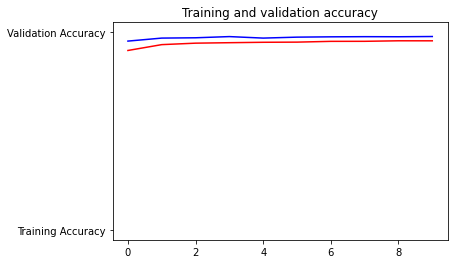

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

In [13]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  print(classes)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving cat.jpg to cat.jpg
[[0.]]
[0.]
cat.jpg is a cat
